In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, chi2_contingency

In [ ]:
# Load data
df = pd.read_csv('engineered_1.csv')

print(f"Dataset shape: {df.shape}")
print(f"Overall recidivism rate: {df['pretrial_recidivism'].mean()*100:.2f}%\n")
df.columns

Dataset shape: (434235, 54)
Overall recidivism rate: 26.00%



Index(['id', 'docketnumber', 'filingdate', 'offensedate', 'complaintdate',
       'offensedispositiondate', 'disp_date', 'arrest_date', 'casestatus',
       'casecategory', 'casedisposition', 'countyofoffense', 'county',
       'defendantdisplayname', 'name', 'sex', 'race_y', 'ethnicity', 'dob_y',
       'dv_flag', 'juvflag', 'conv_flag', 'cost', 'costadjustment', 'charge',
       'title', 'section', 'subsection', 'grade_x', 'citation',
       'citationcomplaintnumber', 'pretrial_recidivism',
       'misdemeanor_recidivism', 'felony_recidivism', 'other_recidivism',
       'n_in_window_arrests', 'earliest_in_window_arrest', 'pretrial_start',
       'pretrial_end', 'age_at_offense', 'age_group',
       'days_since_last_offense', 'waived_or_dismissed_flag', 'drug_flag',
       'violent_flag', 'property_flag', 'max_charge_severity',
       'min_charge_severity', 'avg_charge_severity', 'std_charge_severity',
       'range_charge_severity', 'num_charges_case', 'num_charges_individual',
     

In [ ]:
# ============================================================================
# 1. Added Features
# ============================================================================

# 1) offense_during_same_year_flag
#    Acceleration indicator:
#    For each person (id) and calendar year, count offenses;
#    flag = 1 if count > 1 else 0.
#    Highlights high-activity repeat behavior within a year.

df['offense_year'] = pd.to_datetime(df['offensedate']).dt.year
year_counts = df.groupby(['id', 'offense_year']).size().reset_index(name='year_offense_count')
df = df.merge(year_counts, on=['id', 'offense_year'], how='left')
df['offense_during_same_year_flag'] = (df['year_offense_count'] > 1).astype(int)
df.drop(columns=['year_offense_count'], inplace=True)


# -----------------------------------------
# 2) prev_recid_flag
#    Signals whether the defendant had ANY
#    pretrial recidivism event BEFORE this case.
#    This is computed within-person, ordered
#    by offense date.

# Ensure date + sort order are correct
df['offensedate'] = pd.to_datetime(df['offensedate'], errors='coerce')
df = df.sort_values(['id', 'offensedate'])

# Make sure outcome is numeric 0/1
df['pretrial_recidivism'] = pd.to_numeric(df['pretrial_recidivism'], errors='coerce').fillna(0)

# prev_recid_flag: did this defendant have ANY prior pretrial_recidivism before this case?
prior_cum = (
    df.groupby('id')['pretrial_recidivism']
      .transform(lambda s: s.shift().fillna(0).cumsum())
)

df['prev_recid_flag'] = (prior_cum > 0).astype(int)


# ----------------------------------------------------
# 3) Offense Type Severity Interactions
#    Interaction: avg severity × (not dismissed)
#    Captures that dismissal affects high-severity cases differently.
#    1 - dismissed/waived

df['severity_dismiss_interaction'] = (
    df['avg_charge_severity'] * (1 - df['waived_or_dismissed_flag'])
)


# ----------------------------------------------------
# 4) Repeat-Within-Case Feature
#    Cases with multiple charges often indicate more serious conduct.

df['multi_charge_flag'] = (df['num_charges_case'] > 1).astype(int)


# ----------------------------------------------------
# 5) Charge Category Intensity
#    Sums drug / violent / property involvement.
#    Higher values → broader offending versatility.

category_cols = ['drug_flag', 'violent_flag', 'property_flag']
df['offense_type_intensity'] = df[category_cols].sum(axis=1)

# Save updated dataframe
df.to_csv("final_engineered.csv", index=False)
print("✓ Saved as final_engineered.csv")

✓ Saved as final_engineered.csv


In [ ]:
df.columns

Index(['id', 'docketnumber', 'filingdate', 'offensedate', 'complaintdate',
       'offensedispositiondate', 'disp_date', 'arrest_date', 'casestatus',
       'casecategory', 'casedisposition', 'countyofoffense', 'county',
       'defendantdisplayname', 'name', 'sex', 'race_y', 'ethnicity', 'dob_y',
       'dv_flag', 'juvflag', 'conv_flag', 'cost', 'costadjustment', 'charge',
       'title', 'section', 'subsection', 'grade_x', 'citation',
       'citationcomplaintnumber', 'pretrial_recidivism',
       'misdemeanor_recidivism', 'felony_recidivism', 'other_recidivism',
       'n_in_window_arrests', 'earliest_in_window_arrest', 'pretrial_start',
       'pretrial_end', 'age_at_offense', 'age_group',
       'days_since_last_offense', 'waived_or_dismissed_flag', 'drug_flag',
       'violent_flag', 'property_flag', 'max_charge_severity',
       'min_charge_severity', 'avg_charge_severity', 'std_charge_severity',
       'range_charge_severity', 'num_charges_case', 'num_charges_individual',
     

In [ ]:
# ============================================================================
# 2. CORRELATION ANALYSIS & CRAMÉR'S V TEST
# ============================================================================

print("="*80)
print("CORRELATION WITH PRETRIAL RECIDIVISM")
print("="*80)

# Numeric features for correlation (including newly engineered ones)
numeric_features = [
    'age_at_offense',
    'days_since_last_offense',
    'waived_or_dismissed_flag',
    'drug_flag',
    'violent_flag',
    'property_flag',
    'max_charge_severity',
    'min_charge_severity',
    'avg_charge_severity',
    'std_charge_severity',
    'range_charge_severity',
    'num_charges_case',
    'num_charges_individual',
    'num_prior_cases',
    'prev_recid_flag',
    'offense_during_same_year_flag',
    'severity_dismiss_interaction',
    'multi_charge_flag',
    'offense_type_intensity'
]

correlations = {}

for feature in numeric_features:
    if feature in df.columns:
        # Drop rows with NaN in either the feature or the target
        valid_data = df[[feature, 'pretrial_recidivism']].dropna()
        if len(valid_data) > 1:  # need at least 2 points for Pearson
            corr, p_value = pearsonr(valid_data[feature], valid_data['pretrial_recidivism'])
            correlations[feature] = {
                'correlation': corr,
                'p_value': p_value,
                'count': len(valid_data)
            }

# Convert to DataFrame and sort by absolute correlation strength
corr_df = pd.DataFrame(correlations).T
corr_df['abs_corr'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values('abs_corr', ascending=False)

print("\nPearson Correlations with pretrial_recidivism (sorted by |correlation|):")
print(corr_df[['correlation', 'p_value', 'abs_corr', 'count']])


# ============================================================================
# CATEGORICAL FEATURES - CRAMÉR'S V TEST
# ============================================================================

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1

    if min_dim == 0:
        return 0
    return np.sqrt(chi2 / (n * min_dim))

print("\n\n")
print("="*80)
print("CRAMÉR'S V FOR CATEGORICAL FEATURES")
print("="*80)

categorical_features = [
    # engineered binary flags
    'prev_recid_flag',
    'offense_during_same_year_flag',
    'multi_charge_flag',

    # engineered categorical versions
    'severity_dismiss_interaction',
    'offense_type_intensity'
]

cramers_results = {}
for feature in categorical_features:
    if feature in df.columns:
        v = cramers_v(df[feature], df['pretrial_recidivism'])
        cramers_results[feature] = v

        contingency = pd.crosstab(df[feature], df['pretrial_recidivism'])
        chi2, p_value, dof, expected = chi2_contingency(contingency)

        print(f"\n{feature}:")
        print(f"  Cramér's V: {v:.4f}")
        print(f"  Chi-square: {chi2:.4f}, p-value: {p_value:.4e}")
        print(f"  Recidivism rates by category:")
        recid_by_cat = df.groupby(feature)['pretrial_recidivism'].agg(['mean', 'count'])
        recid_by_cat['mean'] = recid_by_cat['mean'] * 100
        recid_by_cat.columns = ['Recidivism Rate (%)', 'Count']
        print(recid_by_cat)

# Sort by Cramér's V strength
cramers_df = pd.DataFrame(list(cramers_results.items()), columns=['Feature', 'Cramers_V'])
cramers_df = cramers_df.sort_values('Cramers_V', ascending=False)

print("\n" + "="*80)
print("CRAMÉR'S V SORTED BY STRENGTH")
print("="*80)
print(cramers_df.to_string(index=False))

CORRELATION WITH PRETRIAL RECIDIVISM

Pearson Correlations with pretrial_recidivism (sorted by |correlation|):
                               correlation        p_value  abs_corr     count
offense_during_same_year_flag     0.386296   0.000000e+00  0.386296  434235.0
prev_recid_flag                   0.188186   0.000000e+00  0.188186  434235.0
num_prior_cases                   0.169042   0.000000e+00  0.169042  434235.0
property_flag                     0.126672   0.000000e+00  0.126672  434235.0
days_since_last_offense          -0.117928   0.000000e+00  0.117928  158471.0
num_charges_individual            0.095752   0.000000e+00  0.095752  434235.0
avg_charge_severity               0.074998   0.000000e+00  0.074998  434235.0
min_charge_severity               0.072003   0.000000e+00  0.072003  434235.0
offense_type_intensity            0.068521   0.000000e+00  0.068521  434235.0
violent_flag                     -0.067627   0.000000e+00  0.067627  434235.0
age_at_offense                 

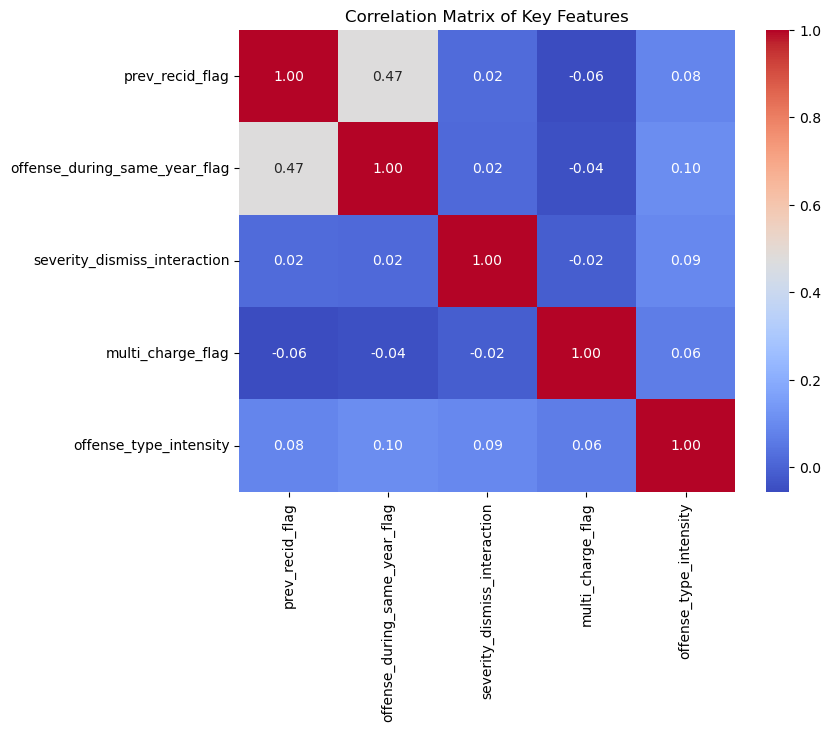

In [ ]:
# CORRELATION MATRIX
features_to_check = [
    'prev_recid_flag',
    'offense_during_same_year_flag',
    'severity_dismiss_interaction',
    'multi_charge_flag',
    'offense_type_intensity'
]

corr_matrix = df[features_to_check].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/1783928242.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/1783928242.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/1783928242.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/1783928242.py:144: UserWarning: set_ticklabels() should only be used with a fixed numbe

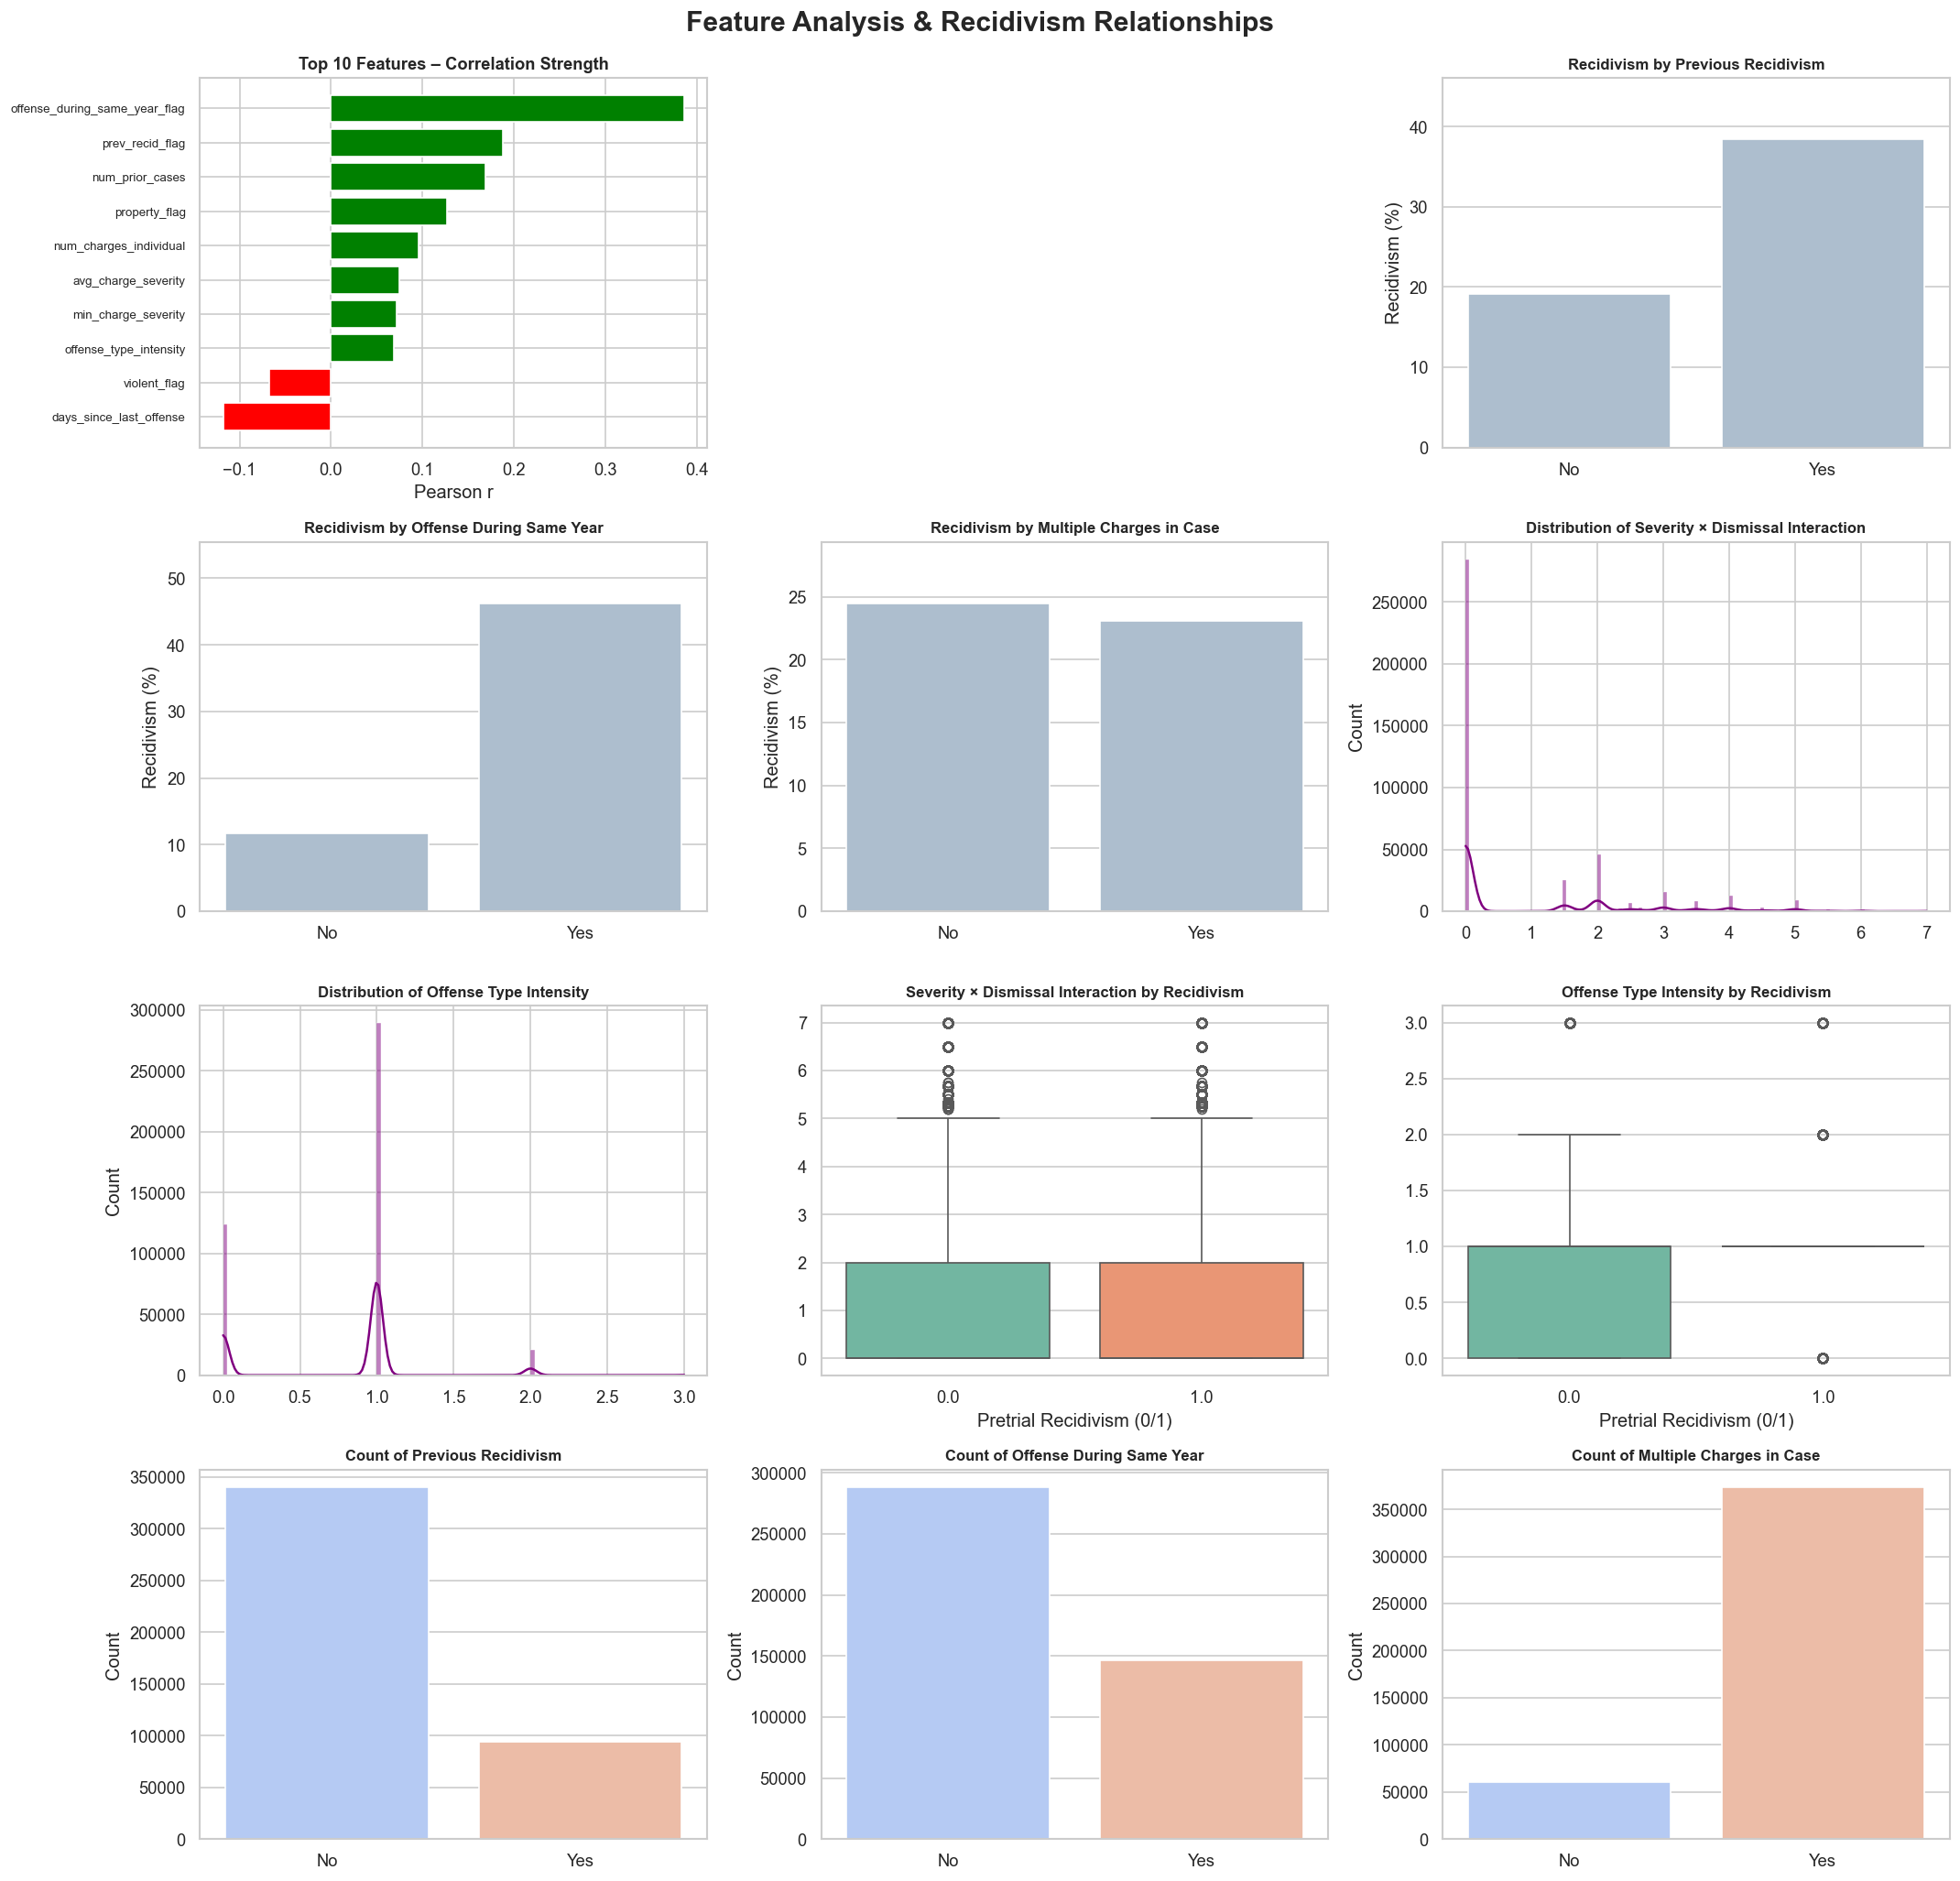

In [ ]:
# ========================================================================
# 3. VISUALIZATIONS – CORR + KEY FEATURE RELATIONSHIPS
# ========================================================================
sns.set(style="whitegrid")

# -------------------------------------------------------------
# CONFIG
# -------------------------------------------------------------
binary_features = [
    'prev_recid_flag',
    'offense_during_same_year_flag',
    'multi_charge_flag'
]

continuous_features = [
    'severity_dismiss_interaction',
    'offense_type_intensity'
]

nice_names_bin = {
    'prev_recid_flag': 'Previous Recidivism',
    'offense_during_same_year_flag': 'Offense During Same Year',
    'multi_charge_flag': 'Multiple Charges in Case'
}

nice_names_cont = {
    'severity_dismiss_interaction': 'Severity × Dismissal Interaction',
    'offense_type_intensity': 'Offense Type Intensity'
}

# -------------------------------------------------------------
# FIGURE LAYOUT (4 rows × 3 cols)
# -------------------------------------------------------------
fig, axes = plt.subplots(4, 3, figsize=(18, 18))
axes = axes.flatten()
ax_idx = 0

fig.suptitle(
    "Feature Analysis & Recidivism Relationships",
    fontsize=18, fontweight="bold", y=0.95
)

# -------------------------------------------------------------
# 1. CORRELATION STRENGTH BAR PLOT
# -------------------------------------------------------------
top_corr = corr_df.head(10)['correlation'].sort_values()
colors = ['red' if v < 0 else 'green' for v in top_corr.values]

axes[ax_idx].barh(range(len(top_corr)), top_corr.values, color=colors)
axes[ax_idx].set_yticks(range(len(top_corr)))
axes[ax_idx].set_yticklabels(top_corr.index, fontsize=8)
axes[ax_idx].set_xlabel("Pearson r")
axes[ax_idx].set_title("Top 10 Features – Correlation Strength",
                       fontsize=11, fontweight="bold")
ax_idx += 1

# leave one cell blank to line things up nicely
axes[ax_idx].axis("off")
ax_idx += 1

# -------------------------------------------------------------
# 2. BINARY FEATURES → MEAN RECIDIVISM (%)
# -------------------------------------------------------------
for feat in binary_features:
    if feat not in df.columns or ax_idx >= len(axes):
        continue

    tmp = df[[feat, 'pretrial_recidivism']].dropna().copy()
    tmp[feat] = tmp[feat].astype(int)

    grp = (
        tmp.groupby(feat)['pretrial_recidivism']
           .mean()
           .reset_index()
    )
    grp['label'] = grp[feat].map({0: "No", 1: "Yes"})
    grp['recidivism_pct'] = grp['pretrial_recidivism'] * 100

    ax = axes[ax_idx]
    sns.barplot(
        data=grp,
        x='label',
        y='recidivism_pct',
        color="#a7bed3",
        ax=ax
    )
    ax.set_ylim(0, max(grp['recidivism_pct']) * 1.2)
    ax.set_xlabel("")
    ax.set_ylabel("Recidivism (%)")
    ax.set_title(f"Recidivism by {nice_names_bin[feat]}",
                 fontsize=10, fontweight="bold")
    ax_idx += 1

# -------------------------------------------------------------
# 3. CONTINUOUS FEATURES – DISTRIBUTION & BOX VS RECIDIVISM
#    (one row: histograms, next row: boxplots)
# -------------------------------------------------------------
# 3a. Histograms
for feat in continuous_features:
    if feat not in df.columns or ax_idx >= len(axes):
        continue

    ax = axes[ax_idx]
    sns.histplot(
        df[feat].dropna(),
        kde=True,
        color="purple",
        ax=ax
    )
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_title(f"Distribution of {nice_names_cont[feat]}",
                 fontsize=10, fontweight="bold")
    ax_idx += 1

# 3b. Boxplots vs recidivism
for feat in continuous_features:
    if feat not in df.columns or ax_idx >= len(axes):
        continue

    ax = axes[ax_idx]
    sns.boxplot(
        x=df['pretrial_recidivism'],
        y=df[feat],
        palette="Set2",
        ax=ax
    )
    ax.set_xlabel("Pretrial Recidivism (0/1)")
    ax.set_ylabel("")
    ax.set_title(f"{nice_names_cont[feat]} by Recidivism",
                 fontsize=10, fontweight="bold")
    ax_idx += 1

# -------------------------------------------------------------
# 4. COUNT PLOTS FOR BINARY FEATURES
# -------------------------------------------------------------
for feat in binary_features:
    if feat not in df.columns or ax_idx >= len(axes):
        continue

    ax = axes[ax_idx]
    sns.countplot(
        x=df[feat].astype(int),
        palette="coolwarm",
        ax=ax
    )
    ax.set_xticklabels(["No", "Yes"])
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.set_title(f"Count of {nice_names_bin[feat]}",
                 fontsize=10, fontweight="bold")
    ax_idx += 1

# Turn off any unused subplots (in case we didn't fill all 12)
for j in range(ax_idx, len(axes)):
    axes[j].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("feature_engineering_overview.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


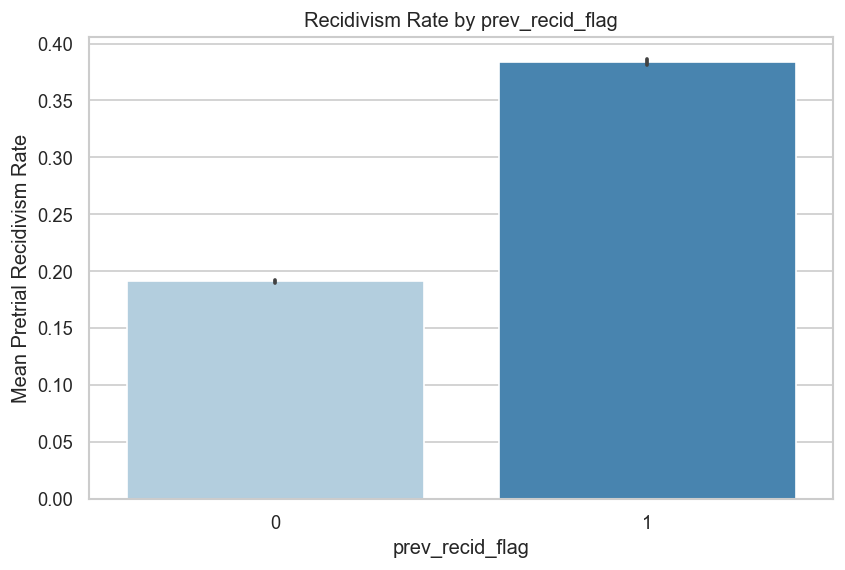

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


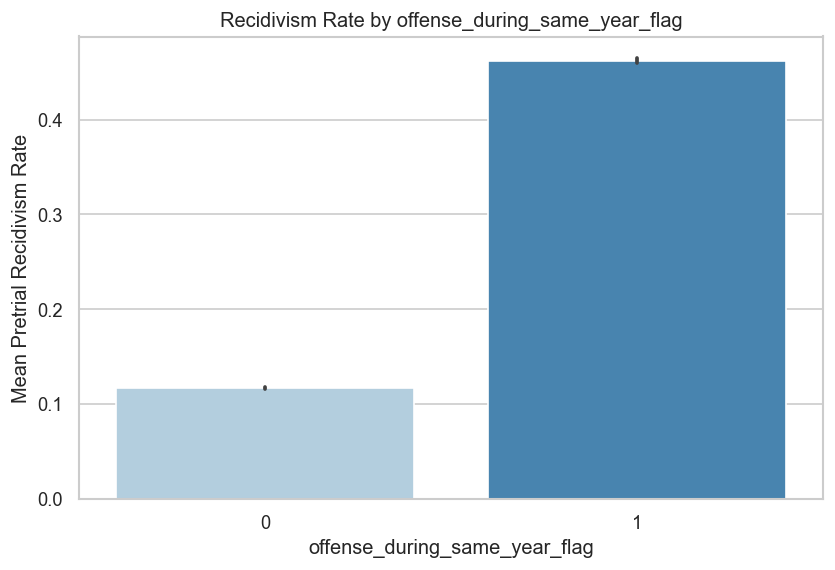

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


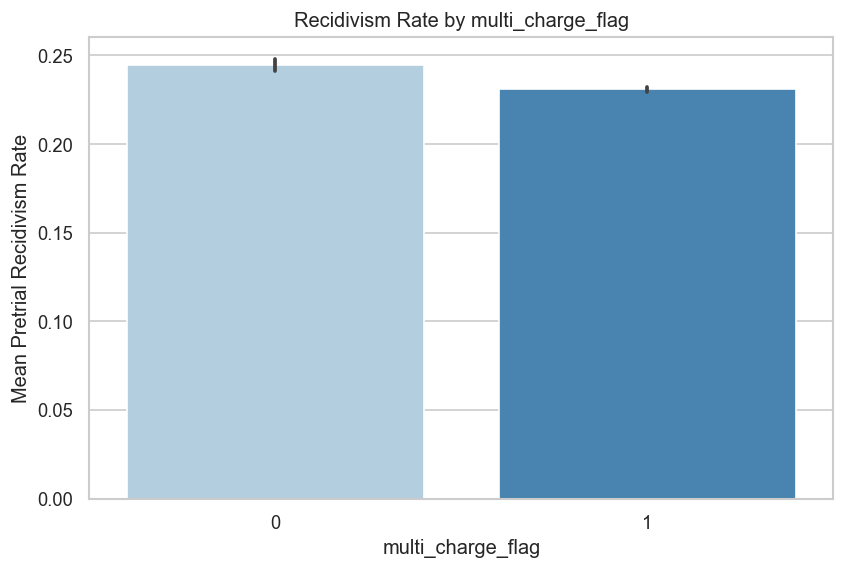

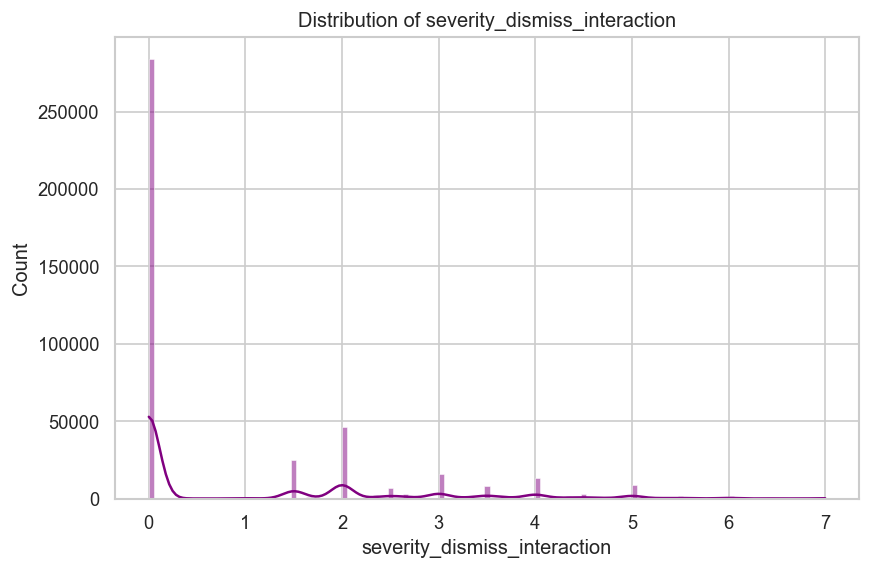

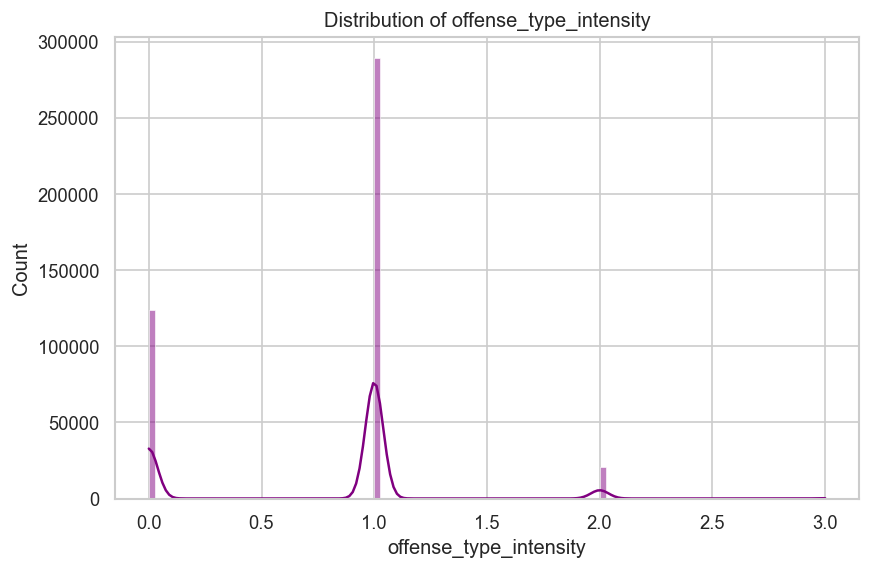

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


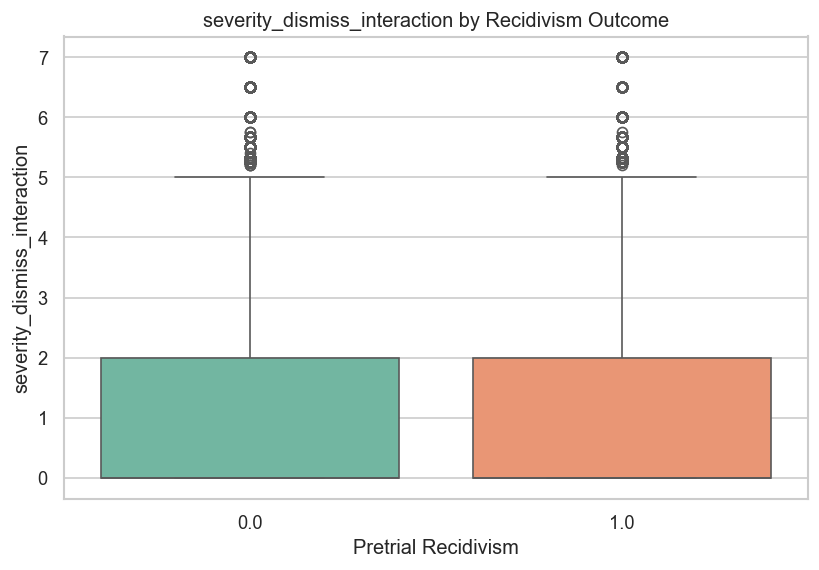

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


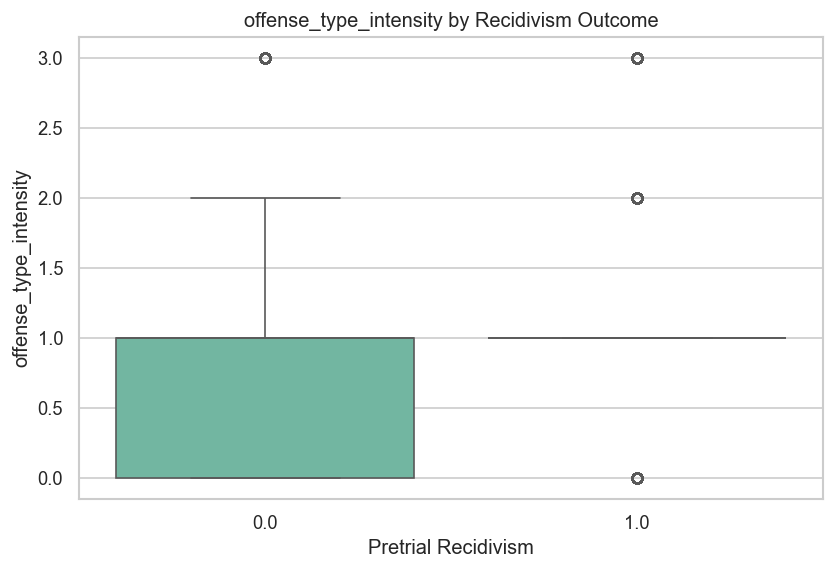

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


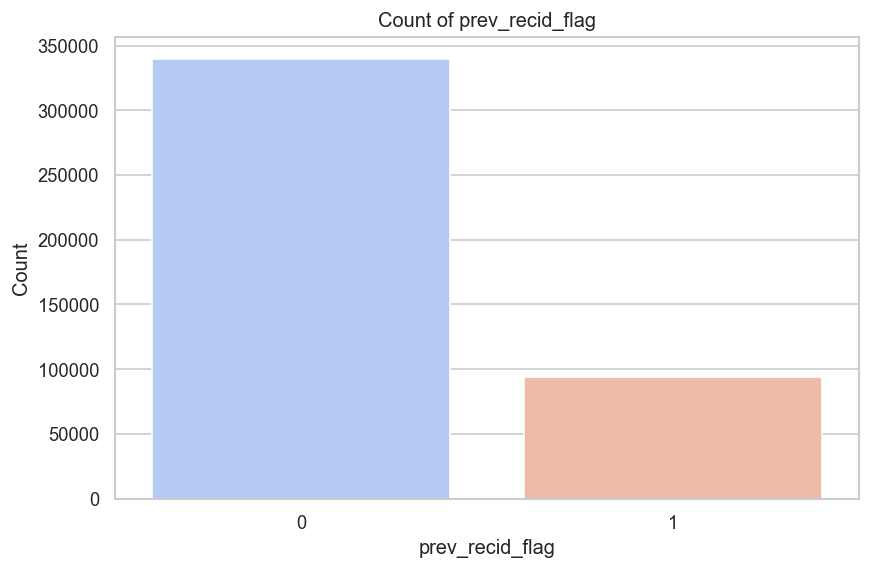

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


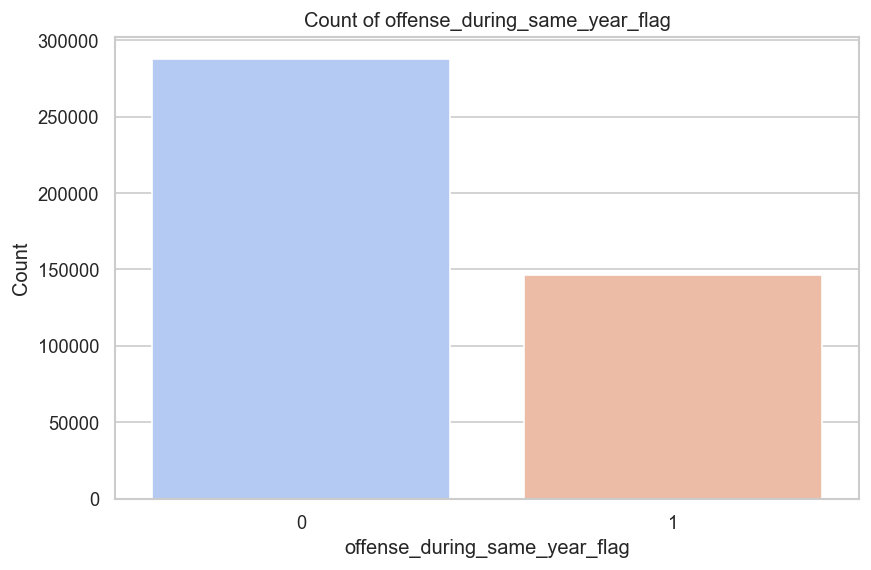

/var/folders/g_/08ph0jh53wq_kpp4fpwvg4hc0000gn/T/ipykernel_22984/2491490086.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


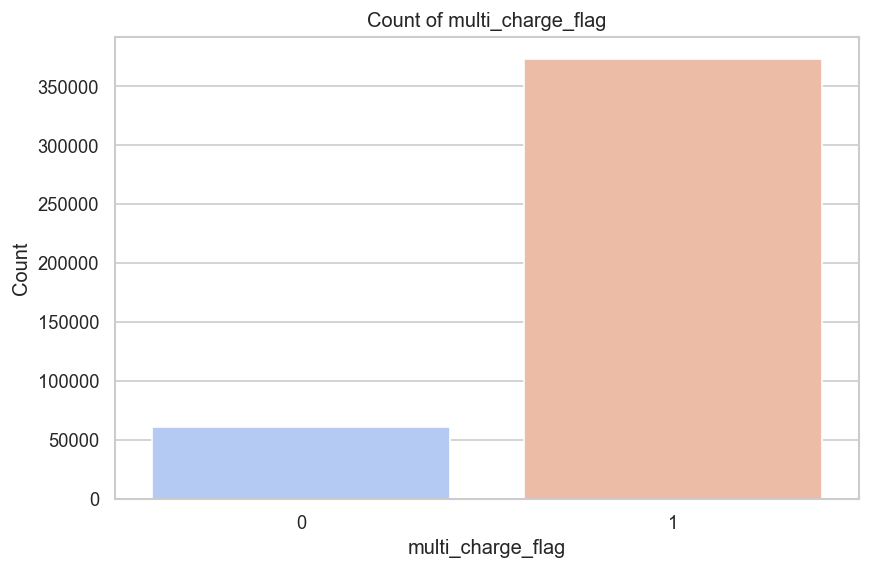

In [ ]:
# =====================================================================
# LARGER PLOTS
# =====================================================================

# Make plots look nice
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# =====================================================================
# 1. BINARY FEATURE → Recidivism Rate
# =====================================================================

binary_features = [
    'prev_recid_flag',
    'offense_during_same_year_flag',
    'multi_charge_flag'
]

for feat in binary_features:
    if feat in df.columns:
        plt.figure()
        sns.barplot(
            x=df[feat].astype(int),
            y=df['pretrial_recidivism'],
            estimator='mean',
            palette="Blues"
        )
        plt.title(f"Recidivism Rate by {feat}")
        plt.xlabel(feat)
        plt.ylabel("Mean Pretrial Recidivism Rate")
        plt.xticks([0, 1])
        plt.show()

# =====================================================================
# 2. DISTRIBUTION PLOTS for CONTINUOUS/INTERACTION FEATURES
# =====================================================================

continuous_features = [
    'severity_dismiss_interaction',
    'offense_type_intensity'
]

for feat in continuous_features:
    if feat in df.columns:
        plt.figure()
        sns.histplot(df[feat], kde=True, color="purple")
        plt.title(f"Distribution of {feat}")
        plt.xlabel(feat)
        plt.ylabel("Count")
        plt.show()

# =====================================================================
# 3. BOX PLOTS: Continuous Feature vs Recidivism
# =====================================================================

for feat in continuous_features:
    if feat in df.columns:
        plt.figure()
        sns.boxplot(
            x=df['pretrial_recidivism'],
            y=df[feat],
            palette="Set2"
        )
        plt.title(f"{feat} by Recidivism Outcome")
        plt.xlabel("Pretrial Recidivism")
        plt.ylabel(feat)
        plt.show()

# =====================================================================
# 4. COUNT PLOTS for BINARY ENGINEERED FEATURES
# =====================================================================

for feat in binary_features:
    if feat in df.columns:
        plt.figure()
        sns.countplot(
            x=df[feat].astype(int),
            palette="coolwarm"
        )
        plt.title(f"Count of {feat}")
        plt.xlabel(feat)
        plt.ylabel("Count")
        plt.xticks([0, 1])
        plt.show()